In [139]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
PLOT_PARAMS()

In [18]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [32]:
files_p112 = glob.glob('../data/P112_data/*.fits')
files_p113 = glob.glob('../data/P113_data/*.fits')


In [70]:
def get_galah():
    galah =(Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits',format='fits'))#.to_pandas()

    dr2_ids = np.array(galah['dr2_source_id']).astype('str')
    dr3_ids = np.array(galah['dr3_source_id']).astype('str')
    
    galah.remove_column('dr2_source_id')
    galah.remove_column('dr3_source_id')
    galah = galah.to_pandas()

    galah.insert(2, 'dr2_source_id', dr2_ids)
    galah.insert(3, 'dr3_source_id', dr3_ids)
    
    galah['ph_qual_wise']=galah['ph_qual_wise'].str.decode("utf-8")
    return galah
galah=get_galah()

In [109]:
def combine_table(obj_dir):
    new_df = {'RG_id':[], 'galah_id': [], 'obj_name': []}

    for k, v in obj_dir.items():
        if len(v['rv']) < 4: 
            continue
        result_table = Simbad.query_objectids(v['name'][0])
        result_table = np.array(result_table).astype('str')

        for i in result_table:
            if 'GALAH' in i: 
                galah_name = i.split(' ')[-1]

        new_df['RG_id'].append(k)
        new_df['galah_id'].append(int(galah_name))
        new_df['obj_name'].append(v['name'][0])

    new_df = pd.DataFrame(new_df)

    new_df = pd.merge(new_df, galah[['sobject_id', 'vbroad', 'fe_h', 'Li_fe', 'ruwe_dr2']], left_on='galah_id', right_on='sobject_id')
    new_df['Li_val'] = new_df.fe_h+new_df.Li_fe+1.05

    cols = ['RG_id', 'galah_id', 'obj_name', 'Li_val', 'vbroad', 'fe_h','ruwe_dr2']
    new_df = new_df[cols]
    new_df.sort_values(by=['RG_id'],inplace=True)
    
    new_df = new_df.round(2)
    return new_df

df_p112 = combine_table(obj_dir_p112)
df_p113 = combine_table(obj_dir_p113)


In [115]:
p112_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p112,left_on='sobject_id', right_on='galah_id', how='right')
p113_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p113,left_on='sobject_id', right_on='galah_id', how='right')


In [118]:
p112_galah

,sobject_id,logg,teff,RG_id,galah_id,obj_name,Li_val,vbroad,fe_h,ruwe_dr2
0,150107004201104,1.79,4190.29,1,150107004201104,UCAC4 297-057956,3.41,11.29,-0.28,0.89
1,151230003202196,1.96,4322.00,2,151230003202196,UCAC4 159-007674,2.10,11.37,-0.28,0.96
2,161013005401317,2.18,4737.90,4,161013005401317,TYC 763-2824-1,2.68,8.79,-0.47,0.93
3,161104004801189,1.39,4299.76,5,161104004801189,UCAC4 374-013344,2.96,7.49,-0.64,0.99
4,160129003601260,2.82,5152.44,7,160129003601260,UCAC4 314-010619,2.60,10.03,-0.21,1.00
5,190212001601338,3.13,4899.74,13,190212001601338,2MASS J05354326-0034367,3.34,19.17,-0.00,0.93


5

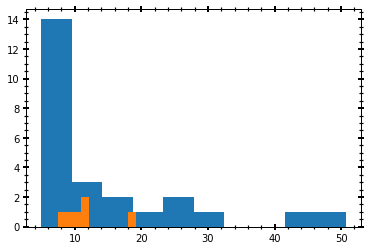

In [156]:
np.min(p113_galah.vbroad), np.max(p113_galah.vbroad)

plt.hist(p113_galah.vbroad)
plt.hist(p112_galah.vbroad)
p113_galah[p113_galah.vbroad <= 10].logg.count()
p113_galah[(p113_galah.vbroad > 10) & (p113_galah.vbroad < 20)].logg.count()
p113_galah[(p113_galah.vbroad >= 20)].logg.count()

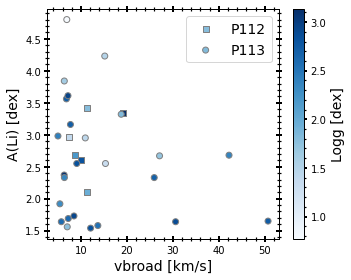

In [203]:
cmap = 'Blues'
vmin = np.min([np.min(p112_galah.logg), np.min(p113_galah.logg)])
vmax = np.max([np.max(p112_galah.logg), np.max(p113_galah.logg)])
plt.figure(figsize=(5,4))
plt.scatter(p112_galah.vbroad, p112_galah.Li_val, marker='s', c=p112_galah.logg, vmin=vmin, vmax=vmax, label='P112', cmap=cmap, ec='grey')
plt.scatter(p113_galah.vbroad, p113_galah.Li_val, marker='o', c=p113_galah.logg, vmin=vmin, vmax=vmax, label='P113', cmap=cmap, ec='grey')
plt.xlabel('vbroad [km/s]')
plt.ylabel('A(Li) [dex]')
plt.colorbar(label='Logg [dex]')
plt.legend()
plt.tight_layout()
#plt.savefig('../plots/ali_vbr.png',bbox_inches='tight',dpi=150)


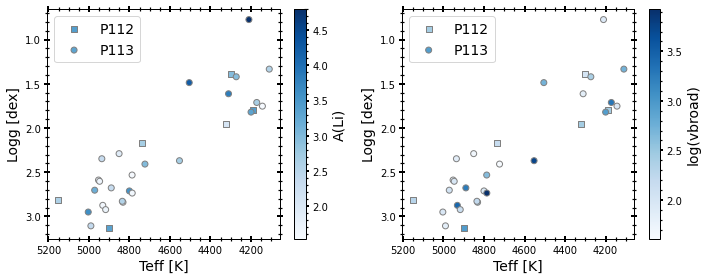

In [202]:
vmin = np.min([np.min(p112_galah.Li_val), np.min(p113_galah.Li_val)])
vmax = np.max([np.max(p112_galah.Li_val), np.max(p113_galah.Li_val)])
cmap = 'Blues'
plt.figure(figsize=(10,4))

ax1=plt.subplot(121)
plt.scatter(p112_galah.teff, p112_galah.logg, marker='s', c=p112_galah.Li_val, vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label='P112')
plt.scatter(p113_galah.teff, p113_galah.logg, c=p113_galah.Li_val, vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label= 'P113')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Teff [K]')
plt.ylabel('Logg [dex]')
plt.legend()
plt.colorbar(label='A(Li)')

ax2=plt.subplot(122,sharex=ax1, sharey=ax1)
vmin = np.log(np.min([np.min(p112_galah.vbroad), np.min(p113_galah.vbroad)]))
vmax = np.log(np.max([np.max(p112_galah.vbroad), np.max(p113_galah.vbroad)]))

plt.scatter(p112_galah.teff, p112_galah.logg, marker='s', c=np.log(p112_galah.vbroad), vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label='P112')
plt.scatter(p113_galah.teff, p113_galah.logg, c=np.log(p113_galah.vbroad), vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label= 'P113')
plt.xlabel('Teff [K]')
plt.ylabel('Logg [dex]')
plt.legend()
plt.colorbar(label='log(vbroad)')
plt.tight_layout()
#plt.savefig('../plots/sample_hrd.png',bbox_inches='tight',dpi=150)


In [66]:
galah_ids_p112 = {
    1: 150107004201104,
    2: 151230003202196,
    4: 161013005401317,
    5: 161104004801189,
    6: 150829004301285,
    7: 160129003601260,
    13: 190212001601338,
    14: 140311007101261,
    23: 170514002101318,
    24: 171208003602294
}

In [87]:
len(df_p112)

18

In [91]:
for k, v in obj_dir_p112.items():
    print(k,len(v['rv']))

24 5
16 2
2 5
5 5
13 5
1 4
8 2
22 2
4 4
6 3
14 3
23 3
7 5
9 1
25 1
20 1
15 1
17 1
12 1


In [215]:
def get_dir(files):
    obj_dir = {}

    counts = []
    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header  = hdul[0].header
            #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
            data    = hdul[1].data
            time    = header['HIERARCH ESO QC BJD']
            name    = header['OBJECT']
            obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
            snr     = header['SNR']
            counts.append(obj)

            grade   = header['OB_GRADE'].replace(" ", "")  
            if grade =='C':
                print('RG',obj,header['OB_GRADE'])
                continue

            ra,dec  = header['RA'], header['DEC']
            obs_T   = header['DATE-OBS'].split('T')[0]
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
            sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            rv_corr = rv_val
            err_corr = rv_err

            if obj in obj_dir.keys():
                obj_dir[obj]['rv'].append(rv_corr)
                obj_dir[obj]['time'].append(time)
                obj_dir[obj]['err'].append(err_corr)
                obj_dir[obj]['name'].append(name)
                obj_dir[obj]['grade'].append(grade)
                obj_dir[obj]['snr'].append(snr)

            else:
                obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 
                                'name': [name], 'grade': [grade], 'snr': [snr]}
          
    targets_to_remove = []
    for k, v in obj_dir.items():
        if len(v['time']) < 4:
            targets_to_remove.append(k)
    for i in range(len(targets_to_remove)):
        del obj_dir[targets_to_remove[i]]
    print(len(obj_dir.keys()))

    myKeys = list(obj_dir.keys())
    myKeys.sort()
    obj_dir = {i: obj_dir[i] for i in myKeys}

    return obj_dir

obj_dir_p112 = get_dir(files_p112)
obj_dir_p113 = get_dir(files_p113)

RG 20 C
RG 13 C
RG 14 C
RG 1 C
7
RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25


In [217]:
P112_snr = []
P113_snr = []

for k, v in obj_dir_p112.items():
    P112_snr.append(v['snr'])

for k, v in obj_dir_p113.items():
    P113_snr.append(v['snr'])
    
P112_snr = list(itertools.chain(*P112_snr))
P113_snr = list(itertools.chain(*P113_snr))

P112
24, 8-78, N=33
P113
24, 5-125, N=129


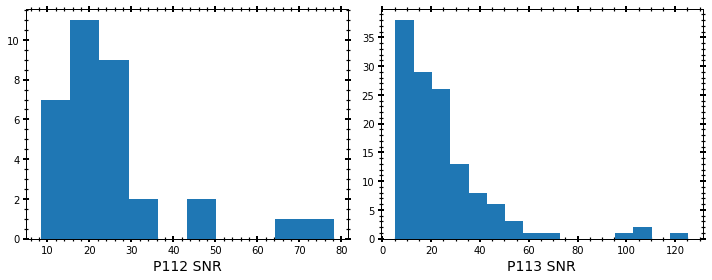

In [218]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(P112_snr,bins='auto')
plt.xlabel('P112 SNR')
plt.subplot(122)
plt.hist(P113_snr,bins='auto')
plt.xlabel('P113 SNR')
plt.tight_layout()


print('P112')
print('%i, %i-%i, N=%i'%(np.mean(P112_snr), np.min(P112_snr), np.max(P112_snr), len(P112_snr)))

print('P113')
print('%i, %i-%i, N=%i'%(np.mean(P113_snr), np.min(P113_snr), np.max(P113_snr), len(P113_snr)))

In [219]:
P112_err = []
P113_err = []

for k, v in obj_dir_p112.items():
    P112_err.append(np.array(v['err']))#/np.array(v['rv']))
    #print(np.array(v['err']),np.array(v['rv']))

print('\n')
for k, v in obj_dir_p113.items():
    P113_err.append(np.array(v['err']))#/np.array(v['rv']))
    #print(np.array(v['err']),np.array(v['rv']))
P112_err = list(itertools.chain(*P112_err))
P113_err = list(itertools.chain(*P113_err))

P112
0.023, 0.001-0.066, N=33
P113
0.040, 0.002-0.112, N=129


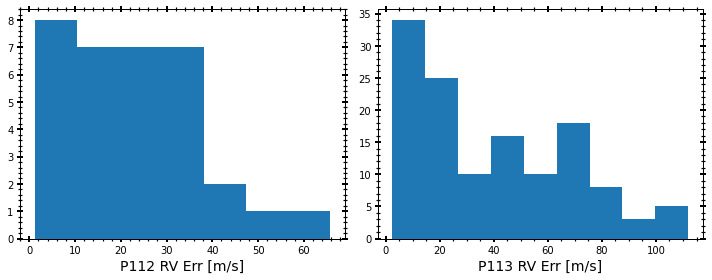

In [220]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist((P112_err*u.km/u.s).to(u.m/u.s).value,bins='auto')
plt.xlabel('P112 RV Err [m/s]')
plt.subplot(122)
plt.hist((P113_err*u.km/u.s).to(u.m/u.s).value,bins='auto')
plt.xlabel('P113 RV Err [m/s]')
plt.tight_layout()


print('P112')
print('%.3f, %.3f-%.3f, N=%i'%(np.mean(P112_err), np.min(P112_err), np.max(P112_err), len(P112_err)))

print('P113')
print('%.3f, %.3f-%.3f, N=%i'%(np.mean(P113_err), np.min(P113_err), np.max(P113_err), len(P113_err)))

In [255]:

obj_dir_p112_new = obj_dir_p112.copy()
obj_dir_p113_new = obj_dir_p113.copy()
obj_dir_p112_new = {'P112-%i' % k:v for k,v in obj_dir_p112_new.items()}
obj_dir_p113_new = {'P113-%i' % k:v for k,v in obj_dir_p113_new.items()}
obj_dir_both = obj_dir_p112_new.copy()
obj_dir_both.update(obj_dir_p113_new)
# myKeys = list(obj_dir_both.keys())
# myKeys.sort()
# obj_dir_both = {i: obj_dir_both[i] for i in myKeys}

print(len(obj_dir_both.keys()))

32


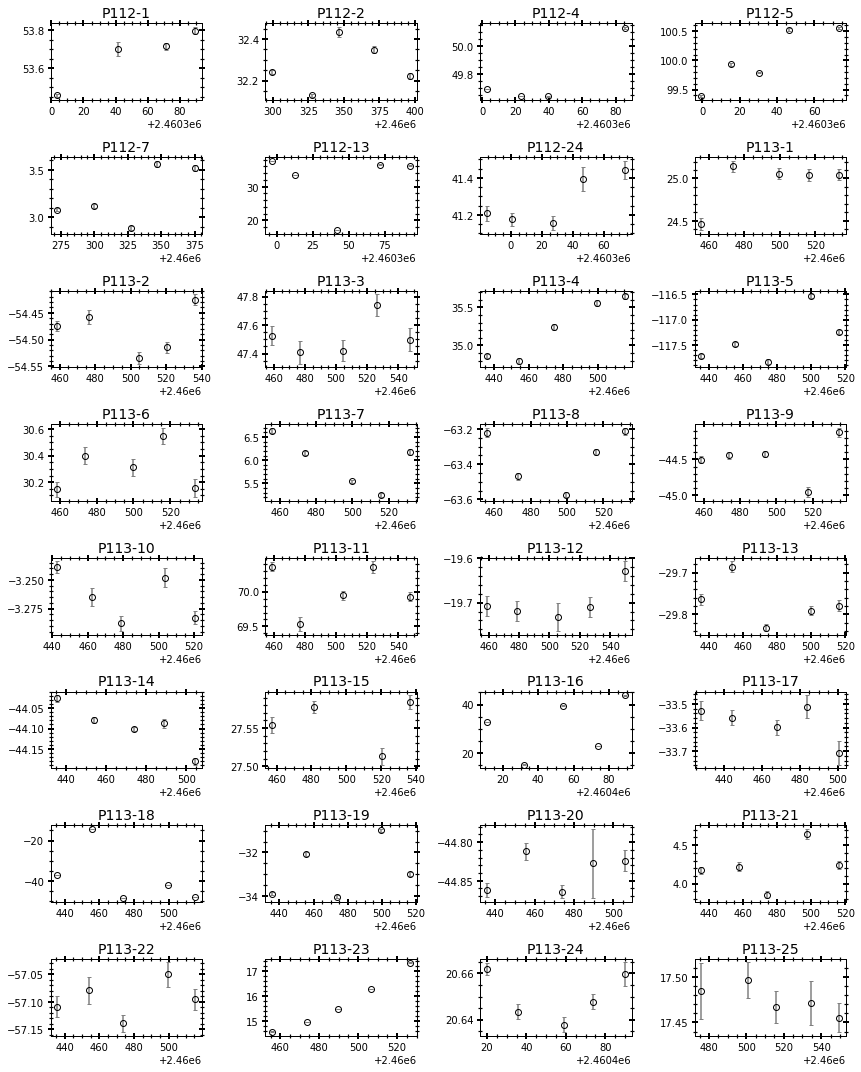

In [260]:
def make_rv_plot(obj_dir):
    #PLOT_PARAMS(LS=12)

    stats = {'RG_id':[], 'A': []}
    plt.figure(figsize=(12,15))
    for i, (obj, dat) in enumerate(obj_dir.items()):
        if len(dat['time']) > 1:
            #obj = int(obj.split('-')[-1])
            #print(obj,obj_dir[obj])
            ax=plt.subplot(8,4,i+1)
            time    = np.array(obj_dir[obj]['time'])
            rv_vals = np.array(obj_dir[obj]['rv'])
            yerr    = np.array(obj_dir[obj]['err'])
            if obj != 'P113-5':
                mask = (rv_vals >= -100)
                time, rv_vals, yerr = time[mask], rv_vals[mask], yerr[mask]
            
            #print(obj)
            t0   = time[0]
            rv0  = rv_vals[0]
            K0   = (max(rv_vals)-min(rv_vals))/2.

            plt.errorbar(time, rv_vals, 
                         yerr=yerr,
                         fmt='o', color='grey', mec='k', mfc='None', capsize=2)
            #plt.axhline(0, color='k',lw=1,ls='dotted')

            diff = abs(max(rv_vals)-min(rv_vals))
            '''if diff < 0.5:
                ax.set_facecolor('lightcoral')
            elif 0.5 <= diff < 0.7:
                ax.set_facecolor('bisque')
            elif 0.7 <= diff <= 50:
                ax.set_facecolor('lightgreen')
            '''
            #li = new_df[new_df.RG_id==obj]['Li_val'].values[0]
            #vb = new_df[new_df.RG_id==obj]['vbroad'].values[0]
            #li, vb = new_df[new_df.RG_id==obj][['Li_val','vbroad']].values()[0]
            #title = 'RG%s: %.2f \n Li=%.2f vb=%.1f'%(obj,diff,li, vb)
            plt.title(obj)
            stats['RG_id'].append(obj)
            stats['A'].append(diff)
    plt.tight_layout()
    plt.show()
    #         elif title in ['RG4','RG24','RG13','RG7']:
    #             ax.set_facecolor('lightblue')
            #if i >= 20: plt.xlabel(r'BJD Time [days]')
        #if i+1 in [1,5,9,13]: plt.ylabel(r'RV [km/s]')

    
1, 2, 4, 5, 7, 13, 24
    #stats = pd.DataFrame(stats)
make_rv_plot(obj_dir_both)
# plt.savefig('../plots/init_%s.png'%DATE, bbox_inches='tight', dpi=200)